In [1]:
import Colors
import Statistics
import FileIO

In [2]:
include("../path.jl")
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry
using .SlcUtil

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


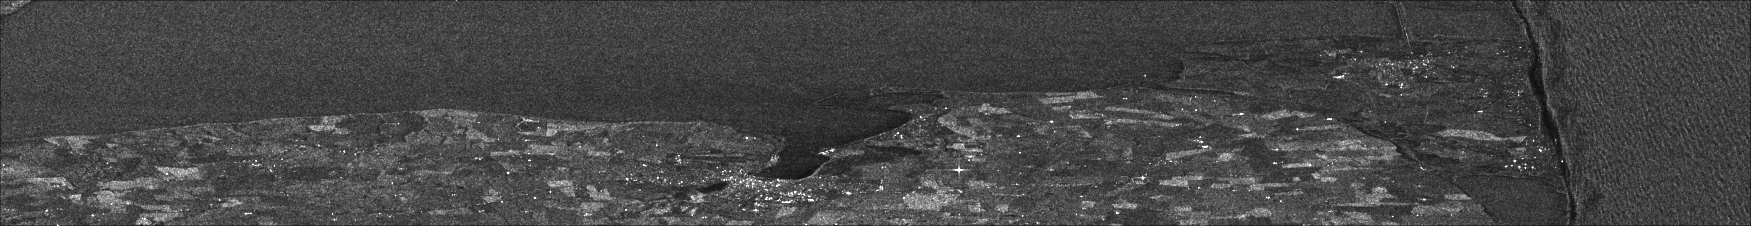

In [3]:
master_view = [500:1400,3000:10000]
master_data = Load.slc_data(master_data_path,master_view)
SlcUtil.show_img(master_data,0.995)

In [4]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [5]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [6]:
lut = look_up_table(master_view,meta,precise_orbit,dem,stride=(2,8));

## Resample

In [7]:
dim = (length(master_view[1]),length(master_view[2]))

(901, 7001)

### load slave image data

In [8]:
padd = 2

slave_view = round(Int,minimum(lut["slave_line"])-padd): round(Int,maximum(lut["slave_line"])+padd),
            round(Int,minimum(lut["slave_sample"])-padd): round(Int,maximum(lut["slave_sample"])+padd)
slave_data = Load.slc_data(slave_data_path, slave_view);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


### Deramp

In [9]:
using Statistics
using DelimitedFiles

In [18]:
v_mid = Geometry.mid_burst_speed(precise_orbit[2], meta[2])[1]
phi = SlcUtil.phase_ramp(Misc.flatten(slave_view...)..., 1, meta[2], v_mid);
deramp = slave_data .* reshape(exp.(- phi .* im), size(slave_data));

(6339525,), (6339525,)

## Resample

In [19]:
slave_resample = Misc.resample(slave_view, deramp, lut["slave_line"], lut["slave_sample"])
slave_resample = reshape(slave_resample, dim);

## reramp

In [20]:
dline = mean(lut["slave_line"] .- lut["master_line"])
dsample = mean(lut["slave_sample"] .- lut["master_sample"])

phi = SlcUtil.phase_ramp(lut["master_line"] .+ dline, lut["master_sample"] .+ dsample, 1, meta[2], v_mid);

# Almost the same but does not work
#phi = Geometry.deramp(lut["slave_line"].+dline,lut["slave_sample"].+dsample,1,meta[2],precise_orbit[2]);

reramp = slave_resample .* reshape(exp.(im .* phi), dim);

(6307901,), (6307901,)

In [21]:
## check spectorgrams

In [14]:
mean_org = mean(slave_data, dims=2);
writedlm("real_original.csv", real.(mean_org));
writedlm("imag_original.csv", imag.(mean_org));
mean_de = mean(de_ramp, dims=2);
writedlm("real_deramped.csv", real.(mean_de));
writedlm("imag_deramped.csv", imag.(mean_de));
mean_re_sa = mean(slave_resample, dims=2);
writedlm("real_resample.csv", real.(mean_re_sa));
writedlm("imag_resample.csv", imag.(mean_re_sa));
mean_re = mean(reramp, dims=2);
writedlm("real_reramped.csv", real.(mean_re));
writedlm("imag_reramped.csv", imag.(mean_re));

UndefVarError: UndefVarError: de_ramp not defined

In [22]:
function plot_phase(img)
    phase = (angle.(img) .+pi)./(2*pi)
    return Colors.RGB{Float32}.(1 .-phase.^2,4 .*(phase .-  phase.^2),phase.^2)
end

plot_phase (generic function with 1 method)

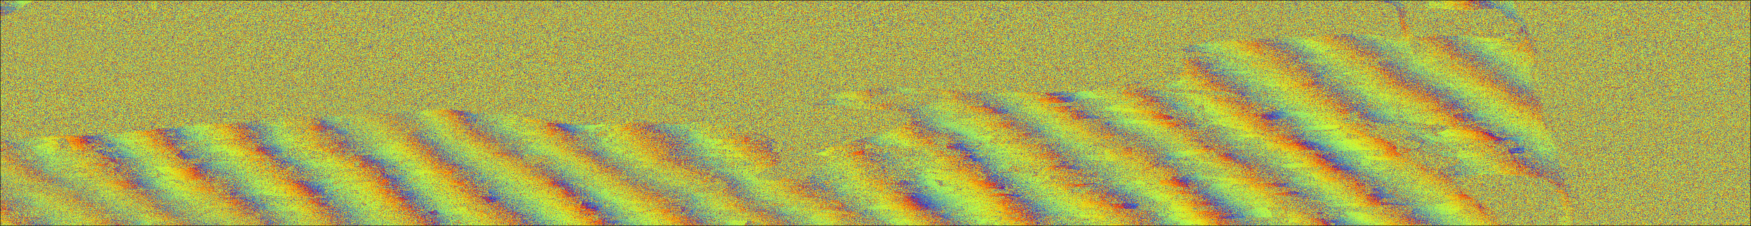

In [23]:
infero = master_data .* conj.(reramp)
plot_phase(infero)

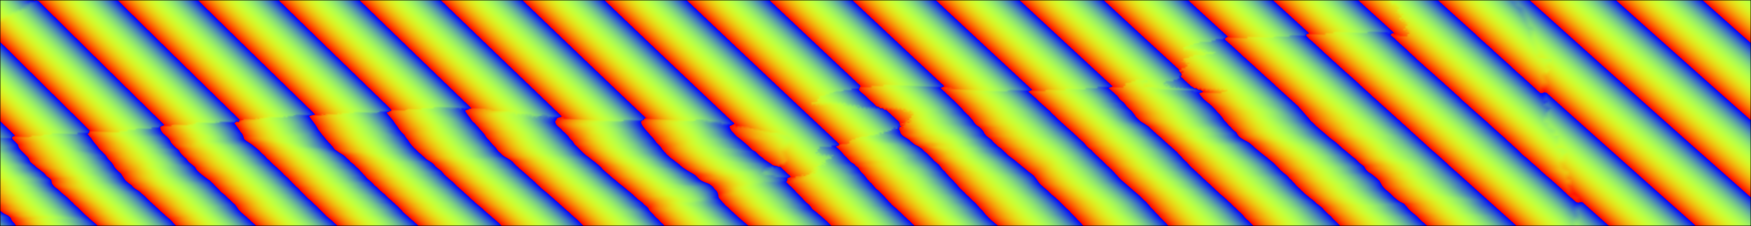

In [24]:
c = 299792458
range_pixel_spacing =  c/(2*meta[1]["range_sampling_rate"])
lambda =  c/meta[1]["radar_frequency"]
flat = exp.(4*pi.*(lut["master_sample"].-lut["slave_sample"]).*range_pixel_spacing./lambda.*im)
flat = reshape(flat,dim);
plot_phase(flat)

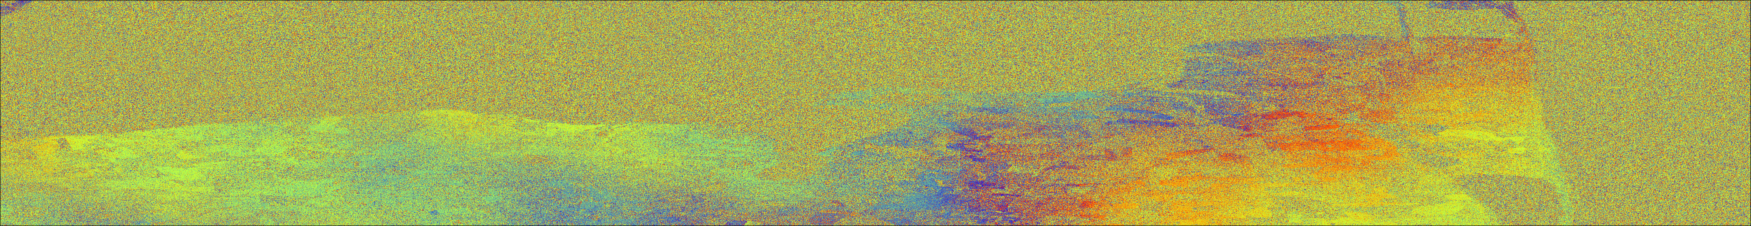

In [26]:
plot_phase(infero.*flat)

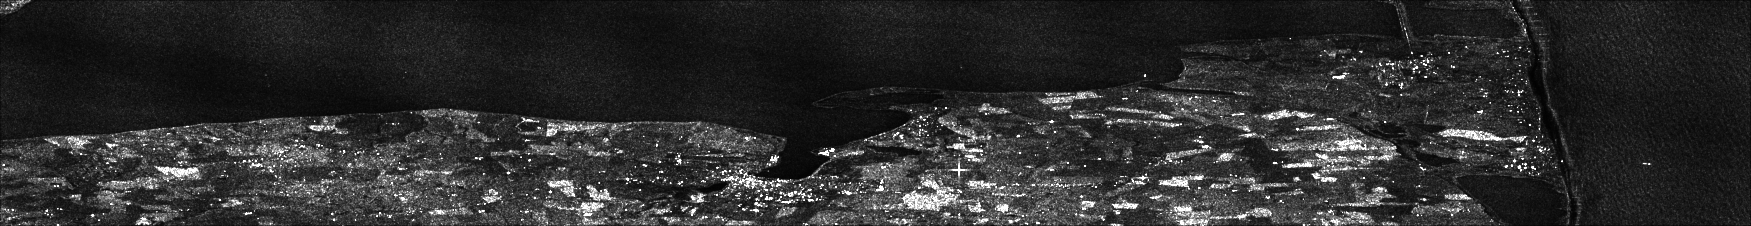

In [21]:
SlcUtil.show_img(infero,0.98)

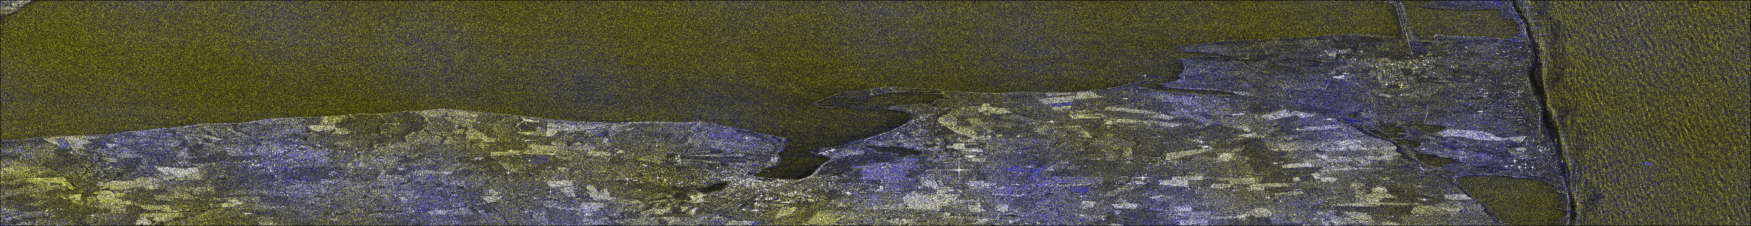

In [22]:
max_quantile = 0.99
temp_master = abs.(master_data)./Statistics.quantile(reshape(abs.(master_data), :), max_quantile)
temp_slave = abs.(slave_resample)./Statistics.quantile(reshape(abs.(slave_resample), :), max_quantile);
temp_master[temp_master .> 1] .= 1
temp_slave[temp_slave .> 1] .= 1

color_img = Colors.RGB{Float32}.(temp_master,temp_master,temp_slave)

In [23]:
FileIO.save("infero_no_flat.jpg",plot_phase(infero.*flat))
FileIO.save("color_img.jpg", color_img)
FileIO.save("infero.jpg", plot_phase(infero))

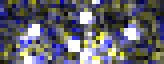

In [24]:
show_lines = 1120-master_view[1].start : 1135-master_view[1].start
show_samples = 6080-master_view[2].start : 6120-master_view[2].start
color_img[show_lines,show_samples]

In [25]:
FileIO.save("resample.jpg", color_img[show_lines,show_samples])